# 과제5 : 데이터 모델링2 - 현민영

라이브러리 불러오기

In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

%config InlineBackend.figure_format = 'retina'  #선명하게 만들기

import warnings
warnings.filterwarnings("ignore")

pd.set_option('display.max_columns', None) # 모든 열 출력

from sklearn.metrics import (
    accuracy_score,
    confusion_matrix,
    f1_score,
    precision_score,
    recall_score,classification_report
)
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

데이터 불러오기

In [3]:
# 작업중인 디렉토리 설정
os.chdir("C:\\Users\\myhyu\\OneDrive\\Desktop\\BAF")
os.getcwd()

'C:\\Users\\myhyu\\OneDrive\\Desktop\\BAF'

In [147]:
train = pd.read_csv("train_clean.csv")
test = pd.read_csv("test_clean.csv")

# 변수 설명   
모든 데이터는 운영일을 기준으로 함.  
선형회귀(Linear Reggresion)을 목표로 진행한 전처리임.  
1차,2차 데이터 전처리 과정은 과제3,4에서 자세히 확인할 수 있음.
  
Target
- BikeCount : 해당 날짜,시각별 자전거 대여 횟수

Feature  
- Date : 날짜
- Hour : 시각
- Temperature : 기온 (℃)
- Humidity : 습도(%)
- Windspeed : 풍속 (m/s)
- Visibility : 가시성 (10m)
- DewpointTem : 이슬점 온도 (℃) (이슬점은 공기 중의 수증기 양을 나타냄)
- SolarRadiation : 지표면에 도달한 태양복사에너지 (MJ/m2)
- Rainfall : 강수량 (mm)
- Snowfall : 강설량 (cm)
- Seasons : 계절
- Holiday : 공휴일 여부

In [5]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7817 entries, 0 to 7816
Data columns (total 27 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Seasons_Autumn      7817 non-null   int64  
 1   Seasons_Spring      7817 non-null   int64  
 2   Seasons_Summer      7817 non-null   int64  
 3   Seasons_Winter      7817 non-null   int64  
 4   Holiday_Holiday     7817 non-null   int64  
 5   Holiday_No Holiday  7817 non-null   int64  
 6   Date                7817 non-null   object 
 7   BikeCount           7817 non-null   int64  
 8   Hour                7817 non-null   int64  
 9   Temperature         7817 non-null   float64
 10  Humidity            7817 non-null   int64  
 11  Windspeed           7817 non-null   float64
 12  Visibility          7817 non-null   int64  
 13  DewpointTem         7817 non-null   float64
 14  SolarRadiation      7817 non-null   float64
 15  Rainfall            7817 non-null   float64
 16  Snowfa

In [129]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 648 entries, 0 to 647
Data columns (total 25 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Seasons_Autumn      648 non-null    int64  
 1   Seasons_Spring      648 non-null    int64  
 2   Seasons_Summer      648 non-null    int64  
 3   Seasons_Winter      648 non-null    int64  
 4   Holiday_Holiday     648 non-null    int64  
 5   Holiday_No Holiday  648 non-null    int64  
 6   Date                648 non-null    object 
 7   Hour                648 non-null    int64  
 8   Temperature         648 non-null    float64
 9   Humidity            648 non-null    int64  
 10  Windspeed           648 non-null    float64
 11  Visibility          648 non-null    int64  
 12  DewpointTem         648 non-null    float64
 13  SolarRadiation      648 non-null    float64
 14  Rainfall            648 non-null    float64
 15  Snowfall            648 non-null    float64
 16  sd_Hour 

test셋을 임의로 분류하였기 때문에 
- 원래 데이터의 11월의 데이터만 추출한 것임.
- 모든 자료는 Seasons_Autumn, Holiday_No Holiday임.

## train, vaild 분리

In [196]:
X_train = train.drop(['BikeCount','sd_BikeCount'], axis = 1).copy()
y_train = train['BikeCount'].copy()

x_train, x_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.2, #valid dataset의 비율 20프로
                                                      shuffle=True, random_state = 0)
x_test = test.copy()

# 1. 모델 학습
## 회귀 문제 모델 평가 
- <span style='background-color:#ffdce0'>결정 계수 (R-squared, R2): 
    - 예측된 값이 target변수의 분산을 설명하는 비율
    - 0~1, 값이 1에 가까울수록 모델이 데이터를 잘 설명한다는 것을 의미
- <span style='background-color:#ffdce0'>평균 제곱 오차 (Mean Squared Error, MSE): 
    - 실제값과 예측값 간의 차이를 제곱하여 평균한 값 
    - 값이 작을수록 모델이 더 정확하게 예측
    - 이상치에 민감
- 평균 절대 오차 (Mean Absolute Error, MSE)
    - 예측값과 실제값의 차이의 절대값의 평균
    - 모델이 평균적으로 얼마나 잘 예측하는지를 나타냄
- 평균 제곱근 오차 (Root Mean Squared Error, RMSE)
    - 예측값과 실제값의 차이의 제곱의 평균의 제곱근, MSE의 제곱근.
    - RMSE가 작을수록 모델의 예측이 실제 값과 가까움.

## 1.1 Linear Reggression
- feature(독립변수)를 통해서 target(종속변수)의 변화(상관관계)를 선형으로 모델링.
- 선형 회귀를 통해 인과관계를 유추할 수 있음.
- MSE : 실제값과 직선 간의 거리가 오차이므로 오차가 작을수록 예측을 잘했다고 볼 수 있음.
- 모든 변수 선택 / 상관관계가 높은 상위 변수만 선택 / 회귀계수가 높은 상위변수만 선택 등 다양한 방식 존재

In [6]:
from sklearn.linear_model import LinearRegression

### 1.1.1 numeric, scaled 데이터셋
데이터셋에서 scaling된 numeric 변수만 선택하여 새로운 데이터셋 생성

In [7]:
# train
x_train1 = x_train.drop(x_train.columns[6:16], axis=1)
y_train1 = y_train.copy()

# valid
x_valid1 = x_valid.drop(x_train.columns[6:16], axis=1)
y_valid1 = y_valid.copy()

# test
x_test1 =  x_test.drop(x_train.columns[6:16], axis=1)

### 1.1.2 모든 변수로 모델학습

In [8]:
model1 = LinearRegression()
# 선형 회귀는 모델 자체가 무작위성을 사용하지 않기 때문에 random_state를 설정할 필요가 없음

In [9]:
# 하이퍼파라미터 확인
print(model1.get_params())

{'copy_X': True, 'fit_intercept': True, 'n_jobs': None, 'positive': False}


In [10]:
model1.fit(x_train1, y_train1)

LinearRegression()

In [11]:
# 모든 feature를 포함하여 선형 회귀 모델 학습
pred1_full = model1.predict(x_valid1)
mse_full = mean_squared_error(y_valid1, pred1_full)
r2_full = r2_score(y_valid1, pred1_full)

### 1.1.3 회귀계수로 변수 선택 후 모델 학습
 Coefficients (회귀계수) 
   - 각 feature의 영향력
   - 양수면 target변수를 증가시키고, 음수면 감소시킴
   - 값이 클수록 영향력이 큼  
   
intercept (y절편)
   - 모든 feature가 0일 때의 target변수의 예측값
   - 모델의 예측을 시작하는 점, 초기 예측값으로 target변수의 기본적이 예측값

In [12]:
coefficients = model1.coef_
intercept = model1.intercept_
coef_df = pd.DataFrame({'Feature': x_train1.columns, 'Coefficient': coefficients})
print(coef_df)
print("y절편:", intercept.round(2))

               Feature  Coefficient
0       Seasons_Autumn   201.409536
1       Seasons_Spring    20.986002
2       Seasons_Summer    25.655785
3       Seasons_Winter  -248.051323
4      Holiday_Holiday   -51.407055
5   Holiday_No Holiday    51.407055
6              sd_Hour   206.265778
7       sd_Temperature   202.864494
8          sd_Humidity  -233.094031
9         sd_Windspeed    10.733970
10       sd_Visibility    -0.422410
11      sd_DewpointTem   127.369371
12   sd_SolarRadiation   -70.979220
13         sd_Rainfall   -69.964778
14         sd_Snowfall    26.812586
y절편: 706.32


- coefficients : 각 feature가 증가할 때 자전거 대여횟수의 증가량
 
- intercept (y절편) : 
     - 모든 feature가 0일 때 target인 자전거 대여횟수의 초기추정치는 706.32
     - 즉, 다른 영향이 없는 경우에도 약 706대의 자전거가 대여될 것으로 예상가능

In [13]:
# 계수와 feature 이름으로 이루어진 데이터프레임 생성
coefficients_df = pd.DataFrame({'Feature': x_train1.columns, 'Coefficient': coefficients})

# 상위 10개의 feature 선택
top_features = coefficients_df.nlargest(10, 'Coefficient')['Feature'].tolist()

# 선택된 feature들만 포함하여 데이터셋 구성
x_train1_coff = x_train1[top_features]
x_valid1_coff = x_valid1[top_features]

# 선형 회귀 모델 학습
model1.fit(x_train1_coff, y_train)

LinearRegression()

In [14]:
# 회귀계수 상위10개 feature를 포함하여 선형 회귀 모델 학습
pred1_coff = model1.predict(x_valid1_coff)
mse_coff = mean_squared_error(y_valid1, pred1_coff)
r2_coff = r2_score(y_valid1, pred1_coff)

### 1.1.4 상관계수로 변수 선택 후 모델 학습

In [15]:
# 타겟 변수와 feature들을 포함하여 상관관계 계산
correlation_matrix = pd.concat([x_train1, y_train], axis=1).corr()

# target과의 상관관계가 높은 상위 10개 feature 선택
top_cor = correlation_matrix.abs().nlargest(11, 'BikeCount')['BikeCount'].index[1:]

In [16]:
top_cor

Index(['sd_Temperature', 'Seasons_Winter', 'sd_Hour', 'sd_DewpointTem',
       'Seasons_Summer', 'sd_SolarRadiation', 'sd_Visibility',
       'Seasons_Autumn', 'sd_Humidity', 'sd_Snowfall'],
      dtype='object')

In [17]:
# 선택된 feature들만 포함하여 데이터셋 구성
x_train1_cor = x_train1[top_cor]
x_valid1_cor = x_valid1[top_cor]

# 선형 회귀 모델 학습
model1.fit(x_train1_cor, y_train1)

# 학습된 모델로 예측
pred1_cor = model1.predict(x_valid1_cor)

### 1.1.5 모델 평가
- [전체 변수 선택 > 상관관계 상위10변수 선택 > 회귀계수 상위10변수 선택] 순서로 예측 성능이 좋음.  
전체 변수를 이용하자!

In [24]:
def model_eval(y_test, y_pred):
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    
    print("R-squared: {:.4f}".format(r2))
    print("MSE: {:.4f}".format(mse))
    print("MAE: {:.4f}".format(mae))
    print("RMSE: {:.4f}".format(rmse))

In [19]:
# 모든 변수 선택
model_eval(y_valid1, pred1_full)

R-squared: 0.5460
MSE: 201057.8515
MAE: 336.8755
RMSE: 448.3947


In [20]:
# 회귀계수가 높은 변수 10개 선택
model_eval(y_valid1, pred1_coff)

R-squared: 0.5178
MSE: 213557.9023
MAE: 347.7326
RMSE: 462.1233


In [21]:
# 상관관계가 높은 변수 8개 선택
model_eval(y_valid1, pred1_cor)

R-squared: 0.5291
MSE: 208535.7478
MAE: 342.8437
RMSE: 456.6571


# 1.2 Decision Tree
- 트리(Tree) 구조를 사용하여 데이터를 분류하거나 예측 
- 일반적으로 데이터의 스케일링이나 정규화가 필요X
- 직관적이며 해석하기 쉬운 모델 : 나무 구조로 데이터의 패턴을 이해하기 쉬움
- 주어진 입력값들의 조합에 대한 의사결정규칙에 따라 출력값 예측
- 범주형 변수와 수치형 변수를 모두 처리할 수 있음.
- 비선형 관계도 모델링 할 수 있음.
- 과적합 Overfitting되기 쉽다는 단점.(일반화 성능이 저하될 수 있음)

In [87]:
from sklearn.tree import DecisionTreeClassifier

In [23]:
model2 = DecisionTreeClassifier(# max_depth = 5,
                        random_state = 42) #실행할 때마다 랜덤한 값을 갖지 않도록 함

In [24]:
#하이퍼파라미터 확인
print(model2.get_params())

{'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': None, 'max_features': None, 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'random_state': 42, 'splitter': 'best'}


### 1.2.1 데이터셋 확인

In [197]:
# train
x_train2 = x_train.drop(x_train.columns[16:25], axis=1)
x_train2 = x_train2.drop(x_train.columns[6], axis=1)
y_train2 = y_train.copy()

# valid
x_valid2 = x_valid.drop(x_train.columns[16:25], axis=1)
x_valid2 = x_valid2.drop(x_train.columns[6], axis=1)
y_valid2 = y_valid.copy()

# test
x_test2 =  x_test.drop(x_train.columns[16:25], axis=1)
x_test2 = x_test2.drop(x_train.columns[6], axis=1)

# scaling을 하지 않은 데이터만 모음.
print(x_train2.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6253 entries, 6661 to 2732
Data columns (total 15 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Seasons_Autumn      6253 non-null   int64  
 1   Seasons_Spring      6253 non-null   int64  
 2   Seasons_Summer      6253 non-null   int64  
 3   Seasons_Winter      6253 non-null   int64  
 4   Holiday_Holiday     6253 non-null   int64  
 5   Holiday_No Holiday  6253 non-null   int64  
 6   Hour                6253 non-null   int64  
 7   Temperature         6253 non-null   float64
 8   Humidity            6253 non-null   int64  
 9   Windspeed           6253 non-null   float64
 10  Visibility          6253 non-null   int64  
 11  DewpointTem         6253 non-null   float64
 12  SolarRadiation      6253 non-null   float64
 13  Rainfall            6253 non-null   float64
 14  Snowfall            6253 non-null   float64
dtypes: float64(6), int64(9)
memory usage: 781.6 KB
None


### 1.2.2 모델 학습

In [26]:
model2.fit(x_train2, y_train2)

DecisionTreeClassifier(random_state=42)

In [27]:
# 의사결정트리 모델 학습
pred2 = model2.predict(x_valid2)
mse2 = mean_squared_error(y_valid2, pred2)
r22 = r2_score(y_valid2, pred2)

### 1.2.3 모델 평가

In [32]:
model_eval(y_valid2, pred2)

R-squared: 0.6586
MSE: 151203.4636
MAE: 240.1260
RMSE: 388.8489


# 1.3 Random Forest
- 의사결정트리(Decision Tree)를 기반으로 한 앙상블(Ensemble) 학습 방법
- 여러 개의 의사결정트리를 생성하고 각 트리의 예측을 종합하여 최종 예측을 수행
- 분류와 회귀 문제에 모두 사용할 수 있음
- 일반화 및 성능이 우수, 과적합이 드물게 일어남
- 하이퍼파라미터 튜닝이 비교적 간단
- 훈련시 메모리 소모가 크다는 단점.
- 개별트리 분석이 어렵고 트리 분리가 복잡해지는 경향 존재.

In [155]:
from sklearn.ensemble import RandomForestClassifier

In [29]:
model3 = RandomForestClassifier(random_state=42)

In [30]:
# 하이퍼파라미터 확인
print(model3.get_params())

{'bootstrap': True, 'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': None, 'max_features': 'sqrt', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 100, 'n_jobs': None, 'oob_score': False, 'random_state': 42, 'verbose': 0, 'warm_start': False}


### 1.3.1 데이터셋 확인

In [31]:
x_train3 = x_train2.copy()
y_train3 = y_train2.copy()
x_valid3 = x_valid2.copy()
y_valid3 = y_valid2.copy()
x_test3 = x_test2.copy()

### 1.3.2 모델 학습

In [33]:
model3.fit(x_train3, y_train3)

RandomForestClassifier(random_state=42)

In [34]:
# 랜덤포레스트 모델 학습
pred3 = model3.predict(x_valid3)
mse3 = mean_squared_error(y_valid3, pred3)
r23 = r2_score(y_valid3, pred3)

### 1.3.3 모델 평가

In [35]:
model_eval(y_valid3, pred3)

R-squared: 0.7415
MSE: 114461.3075
MAE: 196.4022
RMSE: 338.3213


R-squared, MSE, MAE, RMSE를 비교한 결과, 모든 지표에서  
<span style='background-color:#ffdce0'>RandomTree</span>, DecisionTree, LinearReggression 순서로 우수한 성능을 보였다!

# 2. 하이퍼파라미터 튜닝
RandomForestClassifier 하이퍼파라미터
- <span style='background-color:#ffdce0'>n_estimator : 생성할 트리의 개수 </span>  
    많을수록 성능이 향상되지만, 계산비용이 증가
- max_features : 각 노드에서 분할에 사용될 최대 feature 수  
    작은 값은 모델을 간단하게 만들고 다양성을 증가시킬 수 있지만,   
    큰 값은 모델을 더 복잡하게 만들고 과적합의 위험을 증가
- <span style='background-color:#ffdce0'>max_depth : 결정트리의 최대 깊이 </span>   
    깊이가 깊어질수록 모델의 복잡도가 증가하며 과적합의 위험이 커짐.
- <span style='background-color:#ffdce0'>min_samples_split : 노드를 분할하기 위해 필요한 최소한의 샘플 개수</span>  
    증가시키면 분할이 중지되는 경우가 더 많아지므로 모델의 과적합을 방지
- min_samples_leaf : 노드를 분할하기 위해 leaf 노드가 가져야할 최소한의 샘플  
    증가시키면 더 간단한 모델이 생성되며 과적합의 위험이 감소
- max_leaf_nodes : 생성될 수 있는 최대 리프 노드의 개수를 제한
- random_state : 랜덤 시드 지정

In [40]:
# 하이퍼파라미터 확인
print(model3.get_params())

{'bootstrap': True, 'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': None, 'max_features': 'sqrt', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 100, 'n_jobs': None, 'oob_score': False, 'random_state': 42, 'verbose': 0, 'warm_start': False}


## 2.1 Grid Search
가능한 모든 조합을 시도하여 최적의 조합을 찾는 방법

In [36]:
from sklearn.model_selection import GridSearchCV

# 하이퍼파라미터를 딕셔너리로 설정
model= RandomForestClassifier(random_state = 42)

params_grid = {
    'n_estimators' : [100, 200],
    'max_features' : ['sqrt','log2'],
    'max_depth' : [3, 5],
    'min_samples_split' : [5,10]
}

**cross-validation(교차 검증)**
- GridSearchCV()의 CV
- 모델의 성능을 평가하는 방법 중 하나
- 데이터를 여러번 반복해서 나누고 여러 모델을 학습하는 과정을 포함.
- 이를 통해 모델의 일반화 성능을 더 정확하게 평가할 수 있음.
- 특히 데이터가 적을 때 모델의 성능을 신뢰할 수 있는지 확인하는 데 유용

In [37]:
# param_grid 하이퍼파라미터를 3개의 train, valid set fold 로 나누어 테스트 수행
gs = GridSearchCV(estimator=model,param_grid=params_grid , cv = 3) #cv는 cross validation 수

# params_grid 의 하이퍼 파라미터를 순차적으로 학습/평가
gs.fit(x_train3, y_train3)

GridSearchCV(cv=3, estimator=RandomForestClassifier(random_state=42),
             param_grid={'max_depth': [3, 5], 'max_features': ['sqrt', 'log2'],
                         'min_samples_split': [5, 10],
                         'n_estimators': [100, 200]})

In [38]:
gs.best_params_

{'max_depth': 5,
 'max_features': 'sqrt',
 'min_samples_split': 5,
 'n_estimators': 100}

In [39]:
gs.best_score_

0.003998183411044676

### 2.1.2 Grid Search 결과를 df로 저장

In [40]:
gs_result = pd.DataFrame(gs.cv_results_)
gs_result.sort_values('rank_test_score') 

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_max_depth,param_max_features,param_min_samples_split,param_n_estimators,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score
8,6.254603,0.104493,4.930050,0.081642,5,sqrt,5,100,"{'max_depth': 5, 'max_features': 'sqrt', 'min_...",0.003357,0.005278,0.003359,0.003998,0.000905,1
12,6.250967,0.105887,4.812158,0.036901,5,log2,5,100,"{'max_depth': 5, 'max_features': 'log2', 'min_...",0.003357,0.005278,0.003359,0.003998,0.000905,1
9,11.327822,1.576470,11.414692,5.628298,5,sqrt,5,200,"{'max_depth': 5, 'max_features': 'sqrt', 'min_...",0.004317,0.003839,0.003839,0.003998,0.000225,3
13,9.305670,4.363809,8.609648,0.704327,5,log2,5,200,"{'max_depth': 5, 'max_features': 'log2', 'min_...",0.004317,0.003839,0.003839,0.003998,0.000225,3
10,6.205423,0.050994,4.851300,0.036934,5,sqrt,10,100,"{'max_depth': 5, 'max_features': 'sqrt', 'min_...",0.002878,0.003839,0.004798,0.003838,0.000784,5
14,6.140730,0.117388,4.783463,0.002267,5,log2,10,100,"{'max_depth': 5, 'max_features': 'log2', 'min_...",0.002878,0.003839,0.004798,0.003838,0.000784,5
3,7.155390,0.186326,9.626838,0.083755,3,sqrt,10,200,"{'max_depth': 3, 'max_features': 'sqrt', 'min_...",0.003837,0.003359,0.004319,0.003838,0.000392,7
7,7.110737,0.025944,9.725784,0.094737,3,log2,10,200,"{'max_depth': 3, 'max_features': 'log2', 'min_...",0.003837,0.003359,0.004319,0.003838,0.000392,7
1,7.277384,0.149550,9.624414,0.032708,3,sqrt,5,200,"{'max_depth': 3, 'max_features': 'sqrt', 'min_...",0.003357,0.003359,0.003839,0.003518,0.000227,9
5,7.272338,0.115725,9.749865,0.086824,3,log2,5,200,"{'max_depth': 3, 'max_features': 'log2', 'min_...",0.003357,0.003359,0.003839,0.003518,0.000227,9


### 2.1.3 Grid Search 최적의 하이퍼파라미터

In [42]:
gs_model = RandomForestClassifier(random_state=42, max_depth= 5,
                                 min_samples_split= 5,n_estimators= 100)

In [43]:
gs_model.fit(x_train3, y_train3)
pred4 = gs_model.predict(x_valid3)
model_eval(y_valid3, pred4)

R-squared: 0.2036
MSE: 352711.1387
MAE: 371.3638
RMSE: 593.8949


# 2.2 Manual Seacrh

- n_estimator : 생성할 트리의 개수  
많을수록 성능이 향상되지만, 계산비용이 증가  
- max_features : 각 노드에서 분할에 사용될 최대 feature 수   
작은 값은 모델을 간단하게 만들고 다양성을 증가시킬 수 있지만,  
큰 값은 모델을 더 복잡하게 만들고 과적합의 위험을 증가
- max_depth : 결정트리의 최대 깊이  
깊이가 깊어질수록 모델의 복잡도가 증가하며 과적합의 위험이 커짐.
- min_samples_split : 노드를 분할하기 위해 필요한 최소한의 샘플 개수  
증가시키면 분할이 중지되는 경우가 더 많아지므로 모델의 과적합을 방지
- min_samples_leaf : 노드를 분할하기 위해 leaf 노드가 가져야할 최소한의 샘플  
증가시키면 더 간단한 모델이 생성되며 과적합의 위험이 감소
- max_leaf_nodes : 생성될 수 있는 최대 리프 노드의 개수를 제한  
- random_state : 랜덤 시드 지정

In [62]:
print(model3.get_params())

{'bootstrap': True, 'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': None, 'max_features': 'sqrt', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 100, 'n_jobs': None, 'oob_score': False, 'random_state': 42, 'verbose': 0, 'warm_start': False}


In [57]:
# n-estimators 증가 O

## 모델 선언
ms_model = RandomForestClassifier(random_state=42, max_depth= 8,
                                 min_samples_split= 5,n_estimators= 200)

## 모델 학습
ms_model.fit(x_train3, y_train3)

## 모델 평가
pred51 = ms_model.predict(x_valid3)
model_eval(y_valid3, pred51)

R-squared: 0.5250
MSE: 210379.3357
MAE: 274.0914
RMSE: 458.6713


In [65]:
# max_depth 증가 O

## 모델 선언
ms_model = RandomForestClassifier(random_state=42, max_depth= 10,
                                 min_samples_split= 5,n_estimators= 200)

## 모델 학습
ms_model.fit(x_train3, y_train3)

## 모델 평가
pred52 = ms_model.predict(x_valid3)
model_eval(y_valid3, pred52)

R-squared: 0.6346
MSE: 161844.3651
MAE: 241.2040
RMSE: 402.2989


In [66]:
# min_samples_split 증가 X

## 모델 선언
ms_model = RandomForestClassifier(random_state=42, max_depth= 10,
                                 min_samples_split= 7,n_estimators= 200)

## 모델 학습
ms_model.fit(x_train3, y_train3)

## 모델 평가
pred53 = ms_model.predict(x_valid3)
model_eval(y_valid3, pred53)

R-squared: 0.6103
MSE: 172596.3203
MAE: 245.2001
RMSE: 415.4471


In [76]:
# min_samples_leaf 증가 O

## 모델 선언
ms_model = RandomForestClassifier(random_state=42, max_depth= 10,
                                 min_samples_split= 5, min_samples_leaf=5 ,n_estimators= 200)

## 모델 학습
ms_model.fit(x_train3, y_train3)

## 모델 평가
pred54 = ms_model.predict(x_valid3)
model_eval(y_valid3, pred54)

R-squared: 0.7065
MSE: 129964.3184
MAE: 216.8670
RMSE: 360.5056


In [81]:
# max_depth 증가 O

## 모델 선언
ms_model = RandomForestClassifier(random_state=42, max_depth= 20,
                                 min_samples_split= 5, min_samples_leaf=5 ,n_estimators= 300)

## 모델 학습
ms_model.fit(x_train3, y_train3)

## 모델 평가
pred55 = ms_model.predict(x_valid3)
model_eval(y_valid3, pred55)

R-squared: 0.7645
MSE: 104287.5665
MAE: 189.9821
RMSE: 322.9359


기본 모델 : R-squared: 0.7415 / MSE: 114461.3075  
<span style='background-color:#ffdce0'>Manual Search : R-squared: 0.7645 / MSE: 104287.5665

# 3. 변수중요도 확인

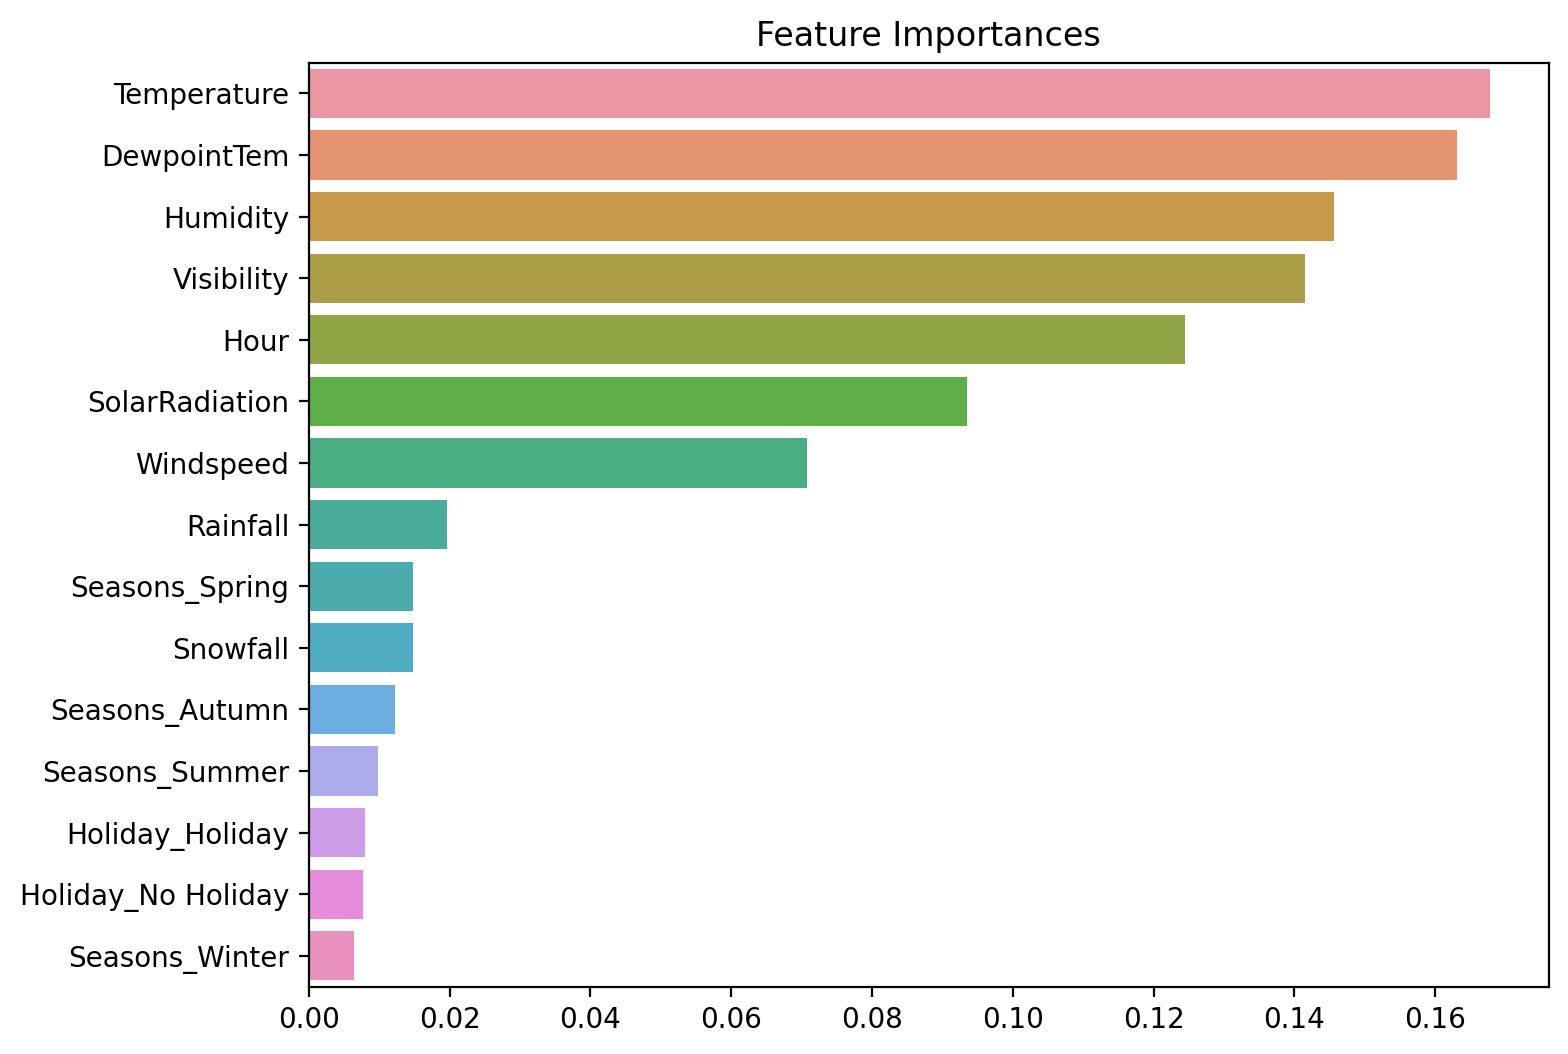

In [86]:
# 변수 중요도 계산
importances_values = pd.Series(ms_model.feature_importances_, index=x_valid3.columns).sort_values(ascending=False)

# 변수 중요도 시각화
plt.figure(figsize=(8,6))
plt.title('Feature Importances')
sns.barplot(x=importances_values, y=importances_values.index)
plt.show()

Temperature, DewpiontTem, Humidity, Visiblity, Hour 순서로 변수 중요도가 높음.
- 기온, 이슬점 온도, 습도 : 이슬점 온도는 기온과 습도에 의해 정해진다는 도메인 지식이 맞다고 할 수 있음.
- 기온, 이슬점온도, 습도, 가시성과 같은 날씨 변수와 자전거 대여량의 관계가 깊은 것을 보아, 상식에 맞는 결과임.
- 시간과 자전거 대여량은 큰 연관이 있음을 알 수 있음.

In [35]:
x_test3.info() 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 648 entries, 0 to 647
Data columns (total 15 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Seasons_Autumn      648 non-null    int64  
 1   Seasons_Spring      648 non-null    int64  
 2   Seasons_Summer      648 non-null    int64  
 3   Seasons_Winter      648 non-null    int64  
 4   Holiday_Holiday     648 non-null    int64  
 5   Holiday_No Holiday  648 non-null    int64  
 6   Hour                648 non-null    int64  
 7   Temperature         648 non-null    float64
 8   Humidity            648 non-null    int64  
 9   Windspeed           648 non-null    float64
 10  Visibility          648 non-null    int64  
 11  DewpointTem         648 non-null    float64
 12  SolarRadiation      648 non-null    float64
 13  Rainfall            648 non-null    float64
 14  Snowfall            648 non-null    float64
dtypes: float64(6), int64(9)
memory usage: 76.1 KB


# 4. 변수 선택
- 변수 중요도를 토대로 7가지 feature선택 후 모델링을 다시 하고자 함.
- Temperature, DewpiontTem, Humidity, Visiblity, Hour, SolorRaidaion, Windspeed
- 6~14행만 선택.

In [215]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7817 entries, 0 to 7816
Data columns (total 27 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Seasons_Autumn      7817 non-null   int64  
 1   Seasons_Spring      7817 non-null   int64  
 2   Seasons_Summer      7817 non-null   int64  
 3   Seasons_Winter      7817 non-null   int64  
 4   Holiday_Holiday     7817 non-null   int64  
 5   Holiday_No Holiday  7817 non-null   int64  
 6   Date                7817 non-null   object 
 7   BikeCount           7817 non-null   int64  
 8   Hour                7817 non-null   int64  
 9   Temperature         7817 non-null   float64
 10  Humidity            7817 non-null   int64  
 11  Windspeed           7817 non-null   float64
 12  Visibility          7817 non-null   int64  
 13  DewpointTem         7817 non-null   float64
 14  SolarRadiation      7817 non-null   float64
 15  Rainfall            7817 non-null   float64
 16  Snowfa

In [211]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 648 entries, 0 to 647
Data columns (total 25 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Seasons_Autumn      648 non-null    int64  
 1   Seasons_Spring      648 non-null    int64  
 2   Seasons_Summer      648 non-null    int64  
 3   Seasons_Winter      648 non-null    int64  
 4   Holiday_Holiday     648 non-null    int64  
 5   Holiday_No Holiday  648 non-null    int64  
 6   Date                648 non-null    object 
 7   Hour                648 non-null    int64  
 8   Temperature         648 non-null    float64
 9   Humidity            648 non-null    int64  
 10  Windspeed           648 non-null    float64
 11  Visibility          648 non-null    int64  
 12  DewpointTem         648 non-null    float64
 13  SolarRadiation      648 non-null    float64
 14  Rainfall            648 non-null    float64
 15  Snowfall            648 non-null    float64
 16  sd_Hour 

In [246]:
train_final = train.iloc[:, 7:15]
test_final = test.iloc[:, 7:14]

In [247]:
X_train = train_final.drop(['BikeCount'], axis = 1).copy()
y_train = train_final['BikeCount'].copy()

x_train, x_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.2, #valid dataset의 비율 20프로
                                                      shuffle=True, random_state = 0)
x_test = test_final.copy()

# 5. 변수 선택 이후 모델링

## 5.1 모델 선택 
선형 회귀 모델은 가장 성능이 좋지 않았으므로, DecisionTree와 RandomForest만 진행.

### 5.1.1 Decision Tree

In [17]:
model6 = DecisionTreeClassifier(random_state = 42)

# 의사결정트리 모델 학습
model6.fit(x_train, y_train)

DecisionTreeClassifier(random_state=42)

In [49]:
pred6 = model6.predict(x_valid)
mse6 = mean_squared_error(y_valid, pred6)
r26 = r2_score(y_valid, pred6)

In [50]:
# 모델 평가
model_eval(y_valid, pred6)

R-squared: 0.9966
MSE: 1485.5345
MAE: 3.8683
RMSE: 38.5426


### 5.1.2 Random Forest
이 부분을 실행하면 계속 오류가 나고 크롬 창 자체 렉을 먹고 꺼져서... 실행해보지 못했습니다...

In [51]:
model7 = RandomForestClassifier(random_state = 42)

# 랜덤포레스트 모델 학습
model7.fit(x_train, y_train)

MemoryError: could not allocate 129761280 bytes

의사결정트리도 r-squred: 0.9966으로 굉장히 높고, MSE : 1485.5345로 굉장히 낮은 수치임. => 좋은 수치  
랜덤포레스트가 실행되지 않는 관계로 <span style='background-color:#ffdce0'>Decision Tree로 모델을 선정.

## 5.2 하이퍼파라미터 튜닝

In [15]:
# 하이퍼파라미터 확인
print(model6.get_params())

{'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': None, 'max_features': None, 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'random_state': 42, 'splitter': 'best'}


### 5.2.1 Grid Search

In [244]:
from sklearn.model_selection import GridSearchCV

# 하이퍼파라미터를 딕셔너리로 설정
model= DecisionTreeClassifier(random_state = 42)

params_grid = {
    'max_features' : ['sqrt','log2'],
    'max_depth' : [None, 3],
    'min_samples_split' : [2, 5],
    'min_samples_leaf': [1,2]
}

In [248]:
# param_grid 하이퍼파라미터를 3개의 train, valid set fold 로 나누어 테스트 수행
gs = GridSearchCV(estimator=model6,param_grid=params_grid , cv = 3) #cv는 cross validation 수

# params_grid 의 하이퍼 파라미터를 순차적으로 학습/평가
gs.fit(x_train, y_train)

GridSearchCV(cv=3, estimator=DecisionTreeClassifier(random_state=42),
             param_grid={'max_depth': [None, 3],
                         'max_features': ['sqrt', 'log2'],
                         'min_samples_leaf': [1, 2],
                         'min_samples_split': [2, 5]})

In [249]:
gs.best_params_

{'max_depth': None,
 'max_features': 'sqrt',
 'min_samples_leaf': 2,
 'min_samples_split': 2}

In [250]:
gs.best_score_

0.005278004084256587

In [251]:
#결과를 df로 저장
gs_result = pd.DataFrame(gs.cv_results_)
gs_result.sort_values('rank_test_score') 

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_max_depth,param_max_features,param_min_samples_leaf,param_min_samples_split,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score
2,0.600669,0.095264,0.022206,0.007284,None,sqrt,2,2,"{'max_depth': None, 'max_features': 'sqrt', 'm...",0.001918,0.007198,0.006718,0.005278,0.002384,1
6,0.645332,0.015495,0.034950,0.009528,None,log2,2,2,"{'max_depth': None, 'max_features': 'log2', 'm...",0.001918,0.007198,0.006718,0.005278,0.002384,1
0,1.033098,0.093455,0.036608,0.008041,None,sqrt,1,2,"{'max_depth': None, 'max_features': 'sqrt', 'm...",0.003357,0.003839,0.005278,0.004158,0.000816,3
4,0.660589,0.008569,0.027910,0.004138,None,log2,1,2,"{'max_depth': None, 'max_features': 'log2', 'm...",0.003357,0.003839,0.005278,0.004158,0.000816,3
8,0.067942,0.007526,0.033917,0.002983,3,sqrt,1,2,"{'max_depth': 3, 'max_features': 'sqrt', 'min_...",0.003357,0.003839,0.003839,0.003678,0.000227,5
9,0.045418,0.010431,0.017703,0.005057,3,sqrt,1,5,"{'max_depth': 3, 'max_features': 'sqrt', 'min_...",0.003357,0.003839,0.003839,0.003678,0.000227,5
10,0.050671,0.004397,0.025209,0.006820,3,sqrt,2,2,"{'max_depth': 3, 'max_features': 'sqrt', 'min_...",0.003357,0.003839,0.003839,0.003678,0.000227,5
11,0.044570,0.012802,0.018765,0.009371,3,sqrt,2,5,"{'max_depth': 3, 'max_features': 'sqrt', 'min_...",0.003357,0.003839,0.003839,0.003678,0.000227,5
12,0.066969,0.003254,0.028483,0.004565,3,log2,1,2,"{'max_depth': 3, 'max_features': 'log2', 'min_...",0.003357,0.003839,0.003839,0.003678,0.000227,5
13,0.073381,0.006872,0.026651,0.007503,3,log2,1,5,"{'max_depth': 3, 'max_features': 'log2', 'min_...",0.003357,0.003839,0.003839,0.003678,0.000227,5


In [255]:
#최적의 하이퍼파라미터
gs_model = DecisionTreeClassifier(random_state = 42, max_depth= None, max_features= 'sqrt',
                                  min_samples_leaf= 2, min_samples_split= 2)
gs_model.fit(x_train, y_train)
pred = gs_model.predict(x_valid)
model_eval(y_valid, pred)

R-squared: 0.6120
MSE: 171811.9041
MAE: 259.1867
RMSE: 414.5020


### 5.2.2 Manual Searh

In [28]:
# 하이퍼파라미터 확인
print(model6.get_params())

{'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': None, 'max_features': None, 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'random_state': 42, 'splitter': 'best'}


In [34]:
# max_depth 증가 X

## 모델 선언
ms_model = DecisionTreeClassifier(random_state=42, max_depth= 3,
                                 min_samples_split= 2, min_samples_leaf =1)

## 모델 학습
ms_model.fit(x_train, y_train)

## 모델 평가
pred = ms_model.predict(x_valid)
model_eval(y_valid, pred)

R-squared: -0.5227
MSE: 674352.8382
MAE: 535.8075
RMSE: 821.1899


In [35]:
# min_samples_leaf 증가 O

## 모델 선언
ms_model = DecisionTreeClassifier(random_state=42, 
                                 min_samples_split= 2, min_samples_leaf =4)

## 모델 학습
ms_model.fit(x_train, y_train)

## 모델 평가
pred = ms_model.predict(x_valid)
model_eval(y_valid, pred)

R-squared: 0.9967
MSE: 1447.5269
MAE: 3.8836
RMSE: 38.0464


In [45]:
# min_samples_split 증가X

## 모델 선언
ms_model = DecisionTreeClassifier(random_state=42, 
                                 min_samples_split=7, min_samples_leaf = 4)

## 모델 학습
ms_model.fit(x_train, y_train)

## 모델 평가
pred = ms_model.predict(x_valid)
model_eval(y_valid, pred)

R-squared: 0.9967
MSE: 1447.5269
MAE: 3.8836
RMSE: 38.0464


In [109]:
# min_samples_leaf 증가 O

## 모델 선언
ms_model = DecisionTreeClassifier(random_state=42, 
                                 min_samples_split= 2, min_samples_leaf = 6)

## 모델 학습
ms_model.fit(x_train, y_train)

## 모델 평가
pred = ms_model.predict(x_valid)
model_eval(y_valid, pred)

R-squared: 0.9975
MSE: 1127.4239
MAE: 3.9879
RMSE: 33.5771


<span style='background-color:#ffdce0'>Best : ms_model = DecisionTreeClassifier(random_state=42,min_samples_split= 2, min_samples_leaf = 6)

# 6. 최종모델 - test 예측

## 6.1 모든 변수 선택

In [203]:
# 모델 : Random Forest
# 하이퍼파라미터 : Manual Search
## 모델 선언
final_model = RandomForestClassifier(random_state=42, max_depth= 20,
                                 min_samples_split= 5, min_samples_leaf=5 ,n_estimators= 300)

In [205]:
final_model.fit(x_train2, y_train2)

RandomForestClassifier(max_depth=20, min_samples_leaf=5, min_samples_split=5,
                       n_estimators=300, random_state=42)

In [206]:
#### test 데이터로 예측
# train
train2 = train.drop(train.columns[16:25], axis=1)
train2 = train2.drop(train.columns[6], axis=1)

# test
test2 =  test.drop(test.columns[16:25], axis=1)
test2 = test2.drop(test.columns[6], axis=1)

test2['BikeCount'] = 0
test2['BikeCount'] = final_model.predict(x_test2)

In [241]:
test2

,Seasons_Autumn,Seasons_Spring,Seasons_Summer,Seasons_Winter,Holiday_Holiday,Holiday_No Holiday,Hour,Temperature,Humidity,Windspeed,Visibility,DewpointTem,SolarRadiation,Rainfall,Snowfall,BikeCount
0,1,0,0,0,0,1,0,5.7,62,2.0,1909,-1.0,0.0,0.0,0.0,531
1,1,0,0,0,0,1,1,5.1,65,2.0,1932,-0.9,0.0,0.0,0.0,531
2,1,0,0,0,0,1,2,4.4,64,1.0,2000,-1.8,0.0,0.0,0.0,123
3,1,0,0,0,0,1,3,4.2,65,1.0,1962,-1.8,0.0,0.0,0.0,123
4,1,0,0,0,0,1,4,3.6,70,1.0,1934,-1.3,0.0,0.0,0.0,123
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
643,1,0,0,0,0,1,19,4.2,34,3.0,1894,-10.3,0.0,0.0,0.0,658
644,1,0,0,0,0,1,20,3.4,37,2.0,2000,-9.9,0.0,0.0,0.0,658
645,1,0,0,0,0,1,21,2.6,39,0.0,1968,-9.9,0.0,0.0,0.0,658
646,1,0,0,0,0,1,22,2.1,41,1.0,1859,-9.8,0.0,0.0,0.0,658


## 6.2 일부만 선택

In [208]:
# 모델 : Decision Tree
# 하이퍼파라미터 : Manual Search
## 모델 선언
final_model = DecisionTreeClassifier(random_state=42, 
                                 min_samples_split= 2, min_samples_leaf = 6)

In [222]:
## 모델 학습
final_model.fit(x_train, y_train)

DecisionTreeClassifier(min_samples_leaf=6, random_state=42)

In [225]:
x_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 648 entries, 0 to 647
Data columns (total 7 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Hour            648 non-null    int64  
 1   Temperature     648 non-null    float64
 2   Humidity        648 non-null    int64  
 3   Windspeed       648 non-null    float64
 4   Visibility      648 non-null    int64  
 5   DewpointTem     648 non-null    float64
 6   SolarRadiation  648 non-null    float64
dtypes: float64(4), int64(3)
memory usage: 35.6 KB


In [227]:
test_final.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 648 entries, 0 to 647
Data columns (total 7 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Hour            648 non-null    int64  
 1   Temperature     648 non-null    float64
 2   Humidity        648 non-null    int64  
 3   Windspeed       648 non-null    float64
 4   Visibility      648 non-null    int64  
 5   DewpointTem     648 non-null    float64
 6   SolarRadiation  648 non-null    float64
dtypes: float64(4), int64(3)
memory usage: 35.6 KB


In [228]:
#### test 데이터로 예측
test_final['BikeCount'] = 0
test_final['BikeCount'] = final_model.predict(x_test)

In [230]:
test_final

,Hour,Temperature,Humidity,Windspeed,Visibility,DewpointTem,SolarRadiation,BikeCount
0,0,5.7,62,2.0,1909,-1.0,0.0,178
1,1,5.1,65,2.0,1932,-0.9,0.0,178
2,2,4.4,64,1.0,2000,-1.8,0.0,122
3,3,4.2,65,1.0,1962,-1.8,0.0,82
4,4,3.6,70,1.0,1934,-1.3,0.0,80
...,...,...,...,...,...,...,...,...
643,19,4.2,34,3.0,1894,-10.3,0.0,189
644,20,3.4,37,2.0,2000,-9.9,0.0,374
645,21,2.6,39,0.0,1968,-9.9,0.0,374
646,22,2.1,41,1.0,1859,-9.8,0.0,374


# 7. k-fold 검증

## 7.1 일부만 선택

In [232]:
X_train = train_final.drop(['BikeCount'], axis =1)
y_train = train_final['BikeCount']

In [233]:
from sklearn.model_selection import KFold

kfold = KFold(n_splits=5, shuffle=True, random_state=10)

In [234]:
model_k = DecisionTreeClassifier(random_state=42, min_samples_split= 2, min_samples_leaf = 6)

In [235]:
r2 = []

for trn_idx, val_idx in kfold.split(X_train):
    
    X_trn, y_trn = X_train.iloc[trn_idx, :], y_train.iloc[trn_idx]
    X_val, y_val = X_train.iloc[val_idx, :], y_train.iloc[val_idx]
    
    model_k.fit(X_trn, y_trn)
    
    y_pred = model_k.predict(X_val)
    
    print('예측 완료')
    
    r2.append(r2_score(y_val, y_pred))

예측 완료
예측 완료
예측 완료
예측 완료
예측 완료


In [236]:
r2

[0.4880615715355542,
 0.4622817842400162,
 0.43128230266015954,
 0.4854457768370182,
 0.48830785105462593]

## 7.2 전체 선택

In [176]:
train = pd.read_csv("train_clean.csv")
test = pd.read_csv("test_clean.csv")

In [182]:
# train
train2 = train.drop(train.columns[16:25], axis=1)
train2 = train2.drop(train.columns[6], axis=1)

# test
test2 =  test.drop(test.columns[16:25], axis=1)
test2 = test2.drop(test.columns[6], axis=1)

In [184]:
X_train = train2.drop(['BikeCount'], axis =1)
y_train = train2['BikeCount']

In [185]:
model_k = RandomForestClassifier(random_state=42, max_depth= 20,
                                 min_samples_split= 5, min_samples_leaf=5 ,n_estimators= 300)

In [186]:
r2 = []

for trn_idx, val_idx in kfold.split(X_train):
    
    X_trn, y_trn = X_train.iloc[trn_idx, :], y_train.iloc[trn_idx]
    X_val, y_val = X_train.iloc[val_idx, :], y_train.iloc[val_idx]
    
    model_k.fit(X_trn, y_trn)
    
    y_pred = model_k.predict(X_val)
    
    print('예측 완료')
    
    r2.append(r2_score(y_val, y_pred))

예측 완료
예측 완료
예측 완료
예측 완료
예측 완료


In [187]:
r2

[0.771647749833791,
 0.7711207001043365,
 0.7538372278511689,
 0.7615449874149431,
 0.7676490220043752]

# 결론
단일 데이터셋과, k-fold 데이터셋에서의 성능 평가 결과가 다름.
- 단일 데이터셋에서의 성능 평가: 
    - 단일 데이터셋에서의 성능 평가는 일반적으로 훈련 데이터셋과 검증 데이터셋 또는 테스트 데이터셋을 나누어서 수행.
    - 이 경우 모델은 전체 데이터셋에서 훈련되고, 훈련 데이터셋에 대한 성능은 단일 지표(예: R^2)로 평가
    - 그러나 이 방법은 특정 데이터셋에 과적합될 수 있으며, 데이터셋의 무작위성에 따라 결과가 달라질 수 있음.

- K-폴드 교차 검증에서의 성능 평가: 
    - K-폴드 교차 검증은 데이터를 여러 번 나누어서 모델을 훈련하고 평가
    - 이 경우 전체 데이터셋이 여러 부분으로 나뉘어지며, 각 부분에 대해 모델이 여러 번 훈련되고 평가
    - 따라서 모델의 성능은 여러 번의 평가를 통해 계산된 평균값으로 나타남.
    - 이 방법은 데이터의 무작위성에 덜 영향을 받으며, 모델의 일반화 성능을 더 잘 반영할 수 있음.

두 방법으로 평가된 모델의 성능이 데이터의 분할 방법과 모델의 일반화에 대한 고려 사항에 따라 다를 수 있다고 함.  
일반적으로는 K-폴드 교차 검증이 모델의 성능을 더 정확히 분석한다고 하므로, 전체 feature를 선택하겠음.

In [243]:
test2.to_csv('test_예측완료_현민영.csv', index = False)